<a id='ldata'></a>
 <a id = "11115"></a><br>

<div>  
<h1><center style="background-color:#c0c0c0; color:black;"><strong>  📈Transaction Forecasting (ML Approaches for Time Series )🚀 </strong></center></h1>
</div>

<img src="https://github.com/Mustafa-YAZICI/-Transaction-Forecasting-ML-Approaches-for-Time-Series-/blob/main/tsf.jpg?raw=true" width="600">

<a id='ldata'></a>
 <a id = "11115"></a><br>

<div>  
<h1><center style="background-color:#c0c0c0; color:black;"><strong>TABLE OF CONTENTS </strong></center></h1>
</div>

1. [Description](#1)
2. [Loading libraries and data](#2)
3. [Understanding the data](#3)

4. [Date Features](#4)
5. [Lag/Shifted Features](#5)
6. [Rolling Mean Features](#6)
7. [Exponentially Weighted Mean Features](#7)
8. [Special Days](#8)
9. [One-Hot Encoding](#9)
10. [Custom Cost Function](#10)

11. [Train,Test, and Validation Sets](#11)
12. [LightGBM Model](#12)
13. [SMAPE](#13)
14. [Result](#14)

<a id='ldata'></a>
 <a id = "1"></a><br>

<div>  
<h1><center style="background-color:#c0c0c0; color:black;"><strong>1. DESCRIPTION </strong></center></h1>
</div>
<a id="Description"></a>

<div style="border-radius:10px;
            border : black solid;
            background-color: #FFFFF;
            font-size:110%;
            text-align: left">

    
    
## Expected Transaction Volume Estimation of Merchants
    
### Business Problem

Iyzico is a financial technology company that facilitates the online shopping experience for both buyers and sellers. It provides payment infrastructure for e-commerce companies, marketplaces and individual users. In this project we make an estimation of the total trading volume, for the first 3 months of 2021.

### Dataset & Variables

> Dataset contains 2018-2021 datas of 7 merchants.

* **transaction_date :** Date of sales
* **merchant_id :** Id's of merchants (Unique number for each merchant)
* **Total_Transaction :** Number of transactions
* **Total_Paid :** Payment amount

<a id = "2" ></a>
# <span style="font-family:serif; font-size:28px;"> 2. Loading libraries and data</span>
<a id="loading"></a>

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('iyzico_data.csv', parse_dates=['transaction_date'],index_col=0)
df.head(5)

,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,2018-01-01,535,349,25883.226
1,2018-01-01,42616,141,40918.860
2,2018-01-01,46774,410,306902.700
3,2018-01-01,86302,10,11.340
4,2018-01-01,124381,285,111383.766


In [3]:
df.shape

(7667, 4)

<a id = "3" ></a>
# <span style="font-family:serif; font-size:28px;"> 3. Understanding the data</span>
<a id = "Undertanding the data" ></a>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7667 entries, 0 to 7666
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_date   7667 non-null   datetime64[ns]
 1   merchant_id        7667 non-null   int64         
 2   Total_Transaction  7667 non-null   int64         
 3   Total_Paid         7667 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 299.5 KB


In [5]:
merchant_ids=df["merchant_id"].unique()
merchant_ids

array([   535,  42616,  46774,  86302, 124381, 129316,  57192],
      dtype=int64)

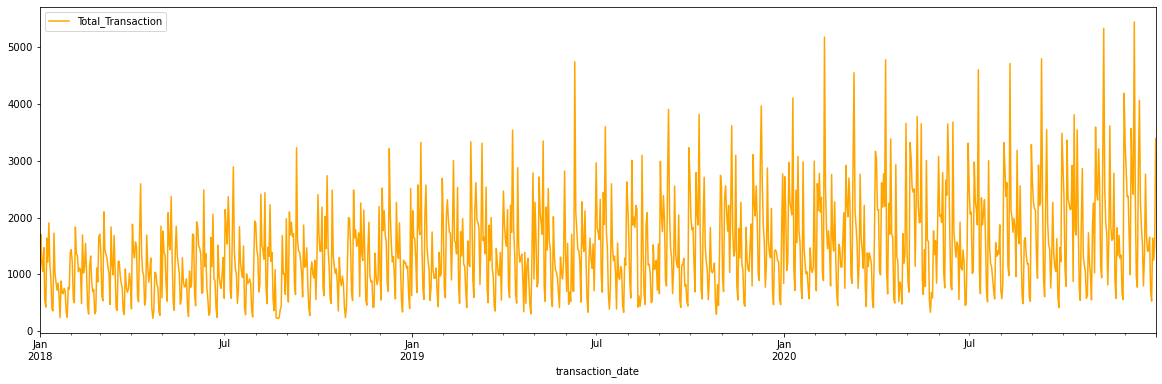

In [6]:
dfx=df[df["merchant_id"]==merchant_ids[2]]
forecast = pd.DataFrame({
    "transaction_date":dfx.transaction_date,
    "Total_Transaction":dfx.Total_Transaction
})

forecast.set_index("transaction_date").Total_Transaction.plot(color = "orange", figsize = (20,6),legend=True);

We will choose one here and make an estimate based on it. You can guess the others.

In [7]:
df=df[df["merchant_id"]==merchant_ids[2]]
df.head(3)

,transaction_date,merchant_id,Total_Transaction,Total_Paid
2,2018-01-01,46774,410,306902.700
8,2018-01-02,46774,1708,1431591.822
14,2018-01-03,46774,1225,1087806.348


<a id = "4" ></a>
# <span style="font-family:serif; font-size:28px;"> 4. Date Features</span>
<a id = "Undertanding the data" ></a>

In [8]:
def create_date_features(df):
    df['month'] = df.transaction_date.dt.month
    df['day_of_month'] = df.transaction_date.dt.day
    df['day_of_year'] = df.transaction_date.dt.dayofyear
    df['week_of_year'] = df.transaction_date.dt.weekofyear
    df['day_of_week'] = df.transaction_date.dt.dayofweek
    df['year'] = df.transaction_date.dt.year
    df["is_wknd"] = df.transaction_date.dt.weekday // 4
    df['is_month_start'] = df.transaction_date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.transaction_date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)
df.head(3)

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0
8,2018-01-02,46774,1708,1431591.822,1,2,2,1,1,2018,0,0,0
14,2018-01-03,46774,1225,1087806.348,1,3,3,1,2,2018,0,0,0


In [9]:
df.groupby(["merchant_id","year"]).agg({"Total_Transaction": ["count"]}).T

merchant_id             46774          
year                     2018 2019 2020
Total_Transaction count   365  365  366

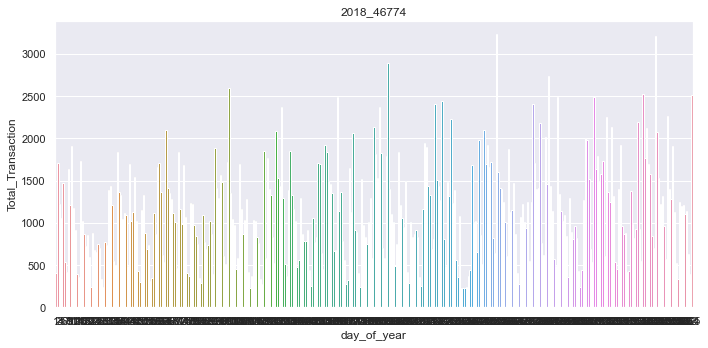

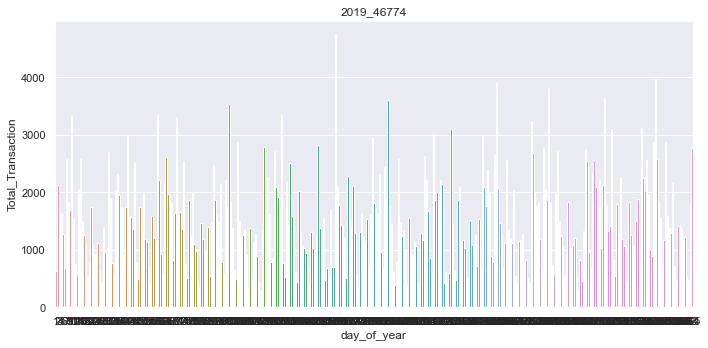

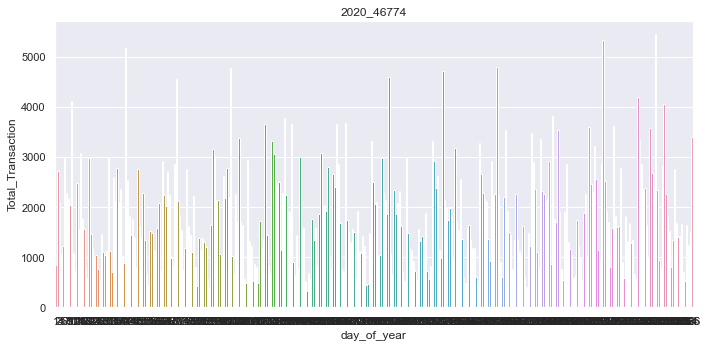

In [10]:
for merchant_id in df.merchant_id.unique():
    for year in df.year.unique():
        plt.figure(figsize=(10, 5))
        sns.set(font_scale=1)
        sns.barplot(x="day_of_year", y="Total_Transaction", data=df[df["merchant_id"]==merchant_id][df["year"]==year])
        plt.title(str(year)+"_"+str(merchant_id))
        plt.tight_layout()
        plt.show()
    break

In [11]:
########################
# Random Noise
########################

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

<a id = "5" ></a>
# <span style="font-family:serif; font-size:28px;"> 5. Lag/Shifted Features</span>
<a id = "Undertanding the data" ></a>

In [12]:
########################
# Lag/Shifted Features
########################

df.sort_values(by=['merchant_id', 'transaction_date'], axis=0, inplace=True)
df.head(3)

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0
8,2018-01-02,46774,1708,1431591.822,1,2,2,1,1,2018,0,0,0
14,2018-01-03,46774,1225,1087806.348,1,3,3,1,2,2018,0,0,0


In [13]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['Total_Transaction_lag_' + str(lag)] = dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
df

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,Total_Transaction_lag_91,Total_Transaction_lag_98,Total_Transaction_lag_105,Total_Transaction_lag_112,Total_Transaction_lag_119,Total_Transaction_lag_126,Total_Transaction_lag_182,Total_Transaction_lag_364,Total_Transaction_lag_546,Total_Transaction_lag_728
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-01-02,46774,1708,1431591.822,1,2,2,1,1,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,2018-01-03,46774,1225,1087806.348,1,3,3,1,2,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,2018-01-04,46774,1056,938222.298,1,4,4,1,3,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,2018-01-05,46774,1469,1188361.620,1,5,5,1,4,2018,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7634,2020-12-27,46774,529,481192.866,12,27,362,52,6,2020,1,0,0,419.307944,1339.895813,606.183826,934.132234,522.478335,485.837256,473.111366,469.301916,1618.605235,399.208109
7641,2020-12-28,46774,1639,1697836.734,12,28,363,53,0,2020,0,0,0,1473.167824,2269.663973,2196.826626,2927.013961,3283.560639,1596.346667,1485.699381,1800.159456,2965.634739,2510.243614
7648,2020-12-29,46774,1250,1343783.286,12,29,364,53,1,2020,0,0,0,1223.798863,1354.077186,3547.894369,2210.318369,2659.386553,1647.204091,3308.181195,2768.280440,1818.095053,627.237503
7655,2020-12-30,46774,1497,1642032.234,12,30,365,53,2,2020,0,0,0,3489.335378,1132.853961,1921.305074,2265.069274,2276.886241,1335.521249,2492.480082,840.412380,1738.899149,2124.196668


<a id = "6" ></a>
# <span style="font-family:serif; font-size:28px;"> 6. Rolling Mean Features</span>
<a id = "Undertanding the data" ></a>

In [14]:
########################
# Rolling Mean Features
########################

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['Total_Paid_roll_mean_' + str(window)] = dataframe.groupby(["merchant_id"])['Total_Paid']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [91,120,182,365, 546,728])
df

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,Total_Transaction_lag_91,Total_Transaction_lag_98,Total_Transaction_lag_105,Total_Transaction_lag_112,Total_Transaction_lag_119,Total_Transaction_lag_126,Total_Transaction_lag_182,Total_Transaction_lag_364,Total_Transaction_lag_546,Total_Transaction_lag_728,Total_Paid_roll_mean_91,Total_Paid_roll_mean_120,Total_Paid_roll_mean_182,Total_Paid_roll_mean_365,Total_Paid_roll_mean_546,Total_Paid_roll_mean_728
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-01-02,46774,1708,1431591.822,1,2,2,1,1,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,2018-01-03,46774,1225,1087806.348,1,3,3,1,2,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,2018-01-04,46774,1056,938222.298,1,4,4,1,3,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,2018-01-05,46774,1469,1188361.620,1,5,5,1,4,2018,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7634,2020-12-27,46774,529,481192.866,12,27,362,52,6,2020,1,0,0,419.307944,1339.895813,606.183826,934.132234,522.478335,485.837256,473.111366,469.301916,1618.605235,399.208109,1.910441e+06,1.831338e+06,1.778462e+06,1.813140e+06,1.774293e+06,1.660127e+06
7641,2020-12-28,46774,1639,1697836.734,12,28,363,53,0,2020,0,0,0,1473.167824,2269.663973,2196.826626,2927.013961,3283.560639,1596.346667,1485.699381,1800.159456,2965.634739,2510.243614,1.910483e+06,1.834985e+06,1.780549e+06,1.812786e+06,1.775178e+06,1.661208e+06
7648,2020-12-29,46774,1250,1343783.286,12,29,364,53,1,2020,0,0,0,1223.798863,1354.077186,3547.894369,2210.318369,2659.386553,1647.204091,3308.181195,2768.280440,1818.095053,627.237503,1.909613e+06,1.838696e+06,1.782712e+06,1.812476e+06,1.776081e+06,1.662289e+06
7655,2020-12-30,46774,1497,1642032.234,12,30,365,53,2,2020,0,0,0,3489.335378,1132.853961,1921.305074,2265.069274,2276.886241,1335.521249,2492.480082,840.412380,1738.899149,2124.196668,1.908328e+06,1.842739e+06,1.785039e+06,1.812111e+06,1.776973e+06,1.663368e+06


In [15]:
# ########################
# # Rolling Mean Features
# ########################


# def roll_mean_features(dataframe, windows):
#     for window in windows:
#         dataframe['Total_Transaction_roll_mean_' + str(window)] = dataframe.groupby(["merchant_id"])['Total_Transaction']. \
#                                                           transform(
#             lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
#             dataframe)
#     return dataframe


# df = roll_mean_features(df, [15,30,45,60,120,182,365, 546,728])
# df

<a id = "7" ></a>
# <span style="font-family:serif; font-size:28px;"> 7. Exponentially Weighted Mean Features</span>
<a id = "Undertanding the data" ></a>

In [16]:
########################
# Exponentially Weighted Mean Features
########################

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['Total_Transaction_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,Total_Transaction_lag_91,Total_Transaction_lag_98,Total_Transaction_lag_105,Total_Transaction_lag_112,Total_Transaction_lag_119,Total_Transaction_lag_126,Total_Transaction_lag_182,Total_Transaction_lag_364,Total_Transaction_lag_546,Total_Transaction_lag_728,Total_Paid_roll_mean_91,Total_Paid_roll_mean_120,Total_Paid_roll_mean_182,Total_Paid_roll_mean_365,Total_Paid_roll_mean_546,Total_Paid_roll_mean_728,Total_Transaction_ewm_alpha_095_lag_91,Total_Transaction_ewm_alpha_095_lag_98,Total_Transaction_ewm_alpha_095_lag_105,Total_Transaction_ewm_alpha_095_lag_112,Total_Transaction_ewm_alpha_095_lag_180,Total_Transaction_ewm_alpha_095_lag_270,Total_Transaction_ewm_alpha_095_lag_365,Total_Transaction_ewm_alpha_095_lag_546,Total_Transaction_ewm_alpha_095_lag_728,Total_Transaction_ewm_alpha_09_lag_91,Total_Transaction_ewm_alpha_09_lag_98,Total_Transaction_ewm_alpha_09_lag_105,Total_Transaction_ewm_alpha_09_lag_112,Total_Transaction_ewm_alpha_09_lag_180,Total_Transaction_ewm_alpha_09_lag_270,Total_Transaction_ewm_alpha_09_lag_365,Total_Transaction_ewm_alpha_09_lag_546,Total_Transaction_ewm_alpha_09_lag_728,Total_Transaction_ewm_alpha_08_lag_91,Total_Transaction_ewm_alpha_08_lag_98,Total_Transaction_ewm_alpha_08_lag_105,Total_Transaction_ewm_alpha_08_lag_112,Total_Transaction_ewm_alpha_08_lag_180,Total_Transaction_ewm_alpha_08_lag_270,Total_Transaction_ewm_alpha_08_lag_365,Total_Transaction_ewm_alpha_08_lag_546,Total_Transaction_ewm_alpha_08_lag_728,Total_Transaction_ewm_alpha_07_lag_91,Total_Transaction_ewm_alpha_07_lag_98,Total_Transaction_ewm_alpha_07_lag_105,Total_Transaction_ewm_alpha_07_lag_112,Total_Transaction_ewm_alpha_07_lag_180,Total_Transaction_ewm_alpha_07_lag_270,Total_Transaction_ewm_alpha_07_lag_365,Total_Transaction_ewm_alpha_07_lag_546,Total_Transaction_ewm_alpha_07_lag_728,Total_Transaction_ewm_alpha_05_lag_91,Total_Transaction_ewm_alpha_05_lag_98,Total_Transaction_ewm_alpha_05_lag_105,Total_Transaction_ewm_alpha_05_lag_112,Total_Transaction_ewm_alpha_05_lag_180,Total_Transaction_ewm_alpha_05_lag_270,Total_Transaction_ewm_alpha_05_lag_365,Total_Transaction_ewm_alpha_05_lag_546,Total_Transaction_ewm_alpha_05_lag_728
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-01-02,46774,1708,1431591.822,1,2,2,1,1,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,2018-01-03,46774,1225,1087806.348,1,3,3,1,2,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,2018-01-04,46774,1056,938222.298,1,4,4,1,3,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,2018-01-05,46774,1469,1188361.620,1,5,5,1,4,2018,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [17]:
df.groupby(["day_of_year"]).agg({"Total_Paid": ["sum"]})

,Total_Paid
,sum
day_of_year,
1,1587165.336
2,6380148.654
3,5207093.424
4,3711044.484
5,3742971.354
...,...
362,2018848.464
363,2594539.494


<a id = "8" ></a>
# <span style="font-family:serif; font-size:28px;"> 8. Special Days</span>
<a id = "Undertanding the data" ></a>

In [18]:
imported_days=[]
ort_=df["Total_Paid"].mean()
for day in df["day_of_year"].unique():
    dfx=df[df["day_of_year"]==day]["Total_Paid"]
    if int(100*dfx.mean()/ort_)<50 or int(100*dfx.mean()/ort_)>150:
        imported_days.append(day)
        if len(imported_days)<5:
            print(day,int(100*dfx.mean()/ort_),dfx.sum()/dfx.std())
        

1 36 7.135060426586279
10 216 6.763134674476763
15 170 8.544087787869108
19 41 11.43781980154911


In [19]:
df[df["day_of_year"]==26][["Total_Paid","merchant_id"]]

,Total_Paid,merchant_id
172,551140.416,46774
2727,562452.372,46774
5282,566839.062,46774


In [20]:
for day in imported_days:
    df["day_"+str(day)]=0
    df.loc[df[df["day_of_year"]==day].index,"day_"+str(day)]=1
df

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,Total_Transaction_lag_91,Total_Transaction_lag_98,Total_Transaction_lag_105,Total_Transaction_lag_112,Total_Transaction_lag_119,Total_Transaction_lag_126,Total_Transaction_lag_182,Total_Transaction_lag_364,Total_Transaction_lag_546,Total_Transaction_lag_728,Total_Paid_roll_mean_91,Total_Paid_roll_mean_120,Total_Paid_roll_mean_182,Total_Paid_roll_mean_365,Total_Paid_roll_mean_546,Total_Paid_roll_mean_728,Total_Transaction_ewm_alpha_095_lag_91,Total_Transaction_ewm_alpha_095_lag_98,Total_Transaction_ewm_alpha_095_lag_105,Total_Transaction_ewm_alpha_095_lag_112,Total_Transaction_ewm_alpha_095_lag_180,Total_Transaction_ewm_alpha_095_lag_270,Total_Transaction_ewm_alpha_095_lag_365,Total_Transaction_ewm_alpha_095_lag_546,Total_Transaction_ewm_alpha_095_lag_728,Total_Transaction_ewm_alpha_09_lag_91,Total_Transaction_ewm_alpha_09_lag_98,Total_Transaction_ewm_alpha_09_lag_105,Total_Transaction_ewm_alpha_09_lag_112,Total_Transaction_ewm_alpha_09_lag_180,Total_Transaction_ewm_alpha_09_lag_270,Total_Transaction_ewm_alpha_09_lag_365,Total_Transaction_ewm_alpha_09_lag_546,Total_Transaction_ewm_alpha_09_lag_728,Total_Transaction_ewm_alpha_08_lag_91,Total_Transaction_ewm_alpha_08_lag_98,Total_Transaction_ewm_alpha_08_lag_105,Total_Transaction_ewm_alpha_08_lag_112,Total_Transaction_ewm_alpha_08_lag_180,Total_Transaction_ewm_alpha_08_lag_270,Total_Transaction_ewm_alpha_08_lag_365,Total_Transaction_ewm_alpha_08_lag_546,Total_Transaction_ewm_alpha_08_lag_728,Total_Transaction_ewm_alpha_07_lag_91,Total_Transaction_ewm_alpha_07_lag_98,Total_Transaction_ewm_alpha_07_lag_105,Total_Transaction_ewm_alpha_07_lag_112,Total_Transaction_ewm_alpha_07_lag_180,Total_Transaction_ewm_alpha_07_lag_270,Total_Transaction_ewm_alpha_07_lag_365,Total_Transaction_ewm_alpha_07_lag_546,Total_Transaction_ewm_alpha_07_lag_728,Total_Transaction_ewm_alpha_05_lag_91,Total_Transaction_ewm_alpha_05_lag_98,Total_Transaction_ewm_alpha_05_lag_105,Total_Transaction_ewm_alpha_05_lag_112,Total_Transaction_ewm_alpha_05_lag_180,Total_Transaction_ewm_alpha_05_lag_270,Total_Transaction_ewm_alpha_05_lag_365,Total_Transaction_ewm_alpha_05_lag_546,Total_Transaction_ewm_alpha_05_lag_728,day_1,day_10,day_15,day_19,day_26,day_27,day_36,day_41,day_42,day_54,day_64,day_65,day_70,day_82,day_83,day_89,day_92,day_99,day_100,day_101,day_106,day_113,day_117,day_126,day_127,day_130,day_136,day_139,day_144,day_145,day_146,day_147,day_161,day_162,day_166,day_173,day_180,day_183,day_191,day_192,day_194,day_208,day_209,day_216,day_217,day_218,day_227,day_235,day_236,day_242,day_246,day_248,day_253,day_254,day_271,day_272,day_274,day_275,day_283,day_292,day_299,day_301,day_302,day_309,day_310,day_315,day_316,day_327,day_336,day_337,day_338,day_339,day_344,day_345,day_350,day_362,day_366
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2018-01-02,46774,1708,1431591.822,1,2,2,1,1,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,2018-01-03,46774,1225,1087806.348,1,3,3,1,2,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

<a id = "9" ></a>
# <span style="font-family:serif; font-size:28px;"> 9. One-Hot Encoding</span>
<a id = "Undertanding the data" ></a>

In [21]:
########################
# One-Hot Encoding
########################

df = pd.get_dummies(df, columns=['merchant_id', 'day_of_week', "week_of_year",'month'])
df

,transaction_date,Total_Transaction,Total_Paid,day_of_month,day_of_year,year,is_wknd,is_month_start,is_month_end,Total_Transaction_lag_91,Total_Transaction_lag_98,Total_Transaction_lag_105,Total_Transaction_lag_112,Total_Transaction_lag_119,Total_Transaction_lag_126,Total_Transaction_lag_182,Total_Transaction_lag_364,Total_Transaction_lag_546,Total_Transaction_lag_728,Total_Paid_roll_mean_91,Total_Paid_roll_mean_120,Total_Paid_roll_mean_182,Total_Paid_roll_mean_365,Total_Paid_roll_mean_546,Total_Paid_roll_mean_728,Total_Transaction_ewm_alpha_095_lag_91,Total_Transaction_ewm_alpha_095_lag_98,Total_Transaction_ewm_alpha_095_lag_105,Total_Transaction_ewm_alpha_095_lag_112,Total_Transaction_ewm_alpha_095_lag_180,Total_Transaction_ewm_alpha_095_lag_270,Total_Transaction_ewm_alpha_095_lag_365,Total_Transaction_ewm_alpha_095_lag_546,Total_Transaction_ewm_alpha_095_lag_728,Total_Transaction_ewm_alpha_09_lag_91,Total_Transaction_ewm_alpha_09_lag_98,Total_Transaction_ewm_alpha_09_lag_105,Total_Transaction_ewm_alpha_09_lag_112,Total_Transaction_ewm_alpha_09_lag_180,Total_Transaction_ewm_alpha_09_lag_270,Total_Transaction_ewm_alpha_09_lag_365,Total_Transaction_ewm_alpha_09_lag_546,Total_Transaction_ewm_alpha_09_lag_728,Total_Transaction_ewm_alpha_08_lag_91,Total_Transaction_ewm_alpha_08_lag_98,Total_Transaction_ewm_alpha_08_lag_105,Total_Transaction_ewm_alpha_08_lag_112,Total_Transaction_ewm_alpha_08_lag_180,Total_Transaction_ewm_alpha_08_lag_270,Total_Transaction_ewm_alpha_08_lag_365,Total_Transaction_ewm_alpha_08_lag_546,Total_Transaction_ewm_alpha_08_lag_728,Total_Transaction_ewm_alpha_07_lag_91,Total_Transaction_ewm_alpha_07_lag_98,Total_Transaction_ewm_alpha_07_lag_105,Total_Transaction_ewm_alpha_07_lag_112,Total_Transaction_ewm_alpha_07_lag_180,Total_Transaction_ewm_alpha_07_lag_270,Total_Transaction_ewm_alpha_07_lag_365,Total_Transaction_ewm_alpha_07_lag_546,Total_Transaction_ewm_alpha_07_lag_728,Total_Transaction_ewm_alpha_05_lag_91,Total_Transaction_ewm_alpha_05_lag_98,Total_Transaction_ewm_alpha_05_lag_105,Total_Transaction_ewm_alpha_05_lag_112,Total_Transaction_ewm_alpha_05_lag_180,Total_Transaction_ewm_alpha_05_lag_270,Total_Transaction_ewm_alpha_05_lag_365,Total_Transaction_ewm_alpha_05_lag_546,Total_Transaction_ewm_alpha_05_lag_728,day_1,day_10,day_15,day_19,day_26,day_27,day_36,day_41,day_42,day_54,day_64,day_65,day_70,day_82,day_83,day_89,day_92,day_99,day_100,day_101,day_106,day_113,day_117,day_126,day_127,day_130,day_136,day_139,day_144,day_145,day_146,day_147,day_161,day_162,day_166,day_173,day_180,day_183,day_191,day_192,day_194,day_208,day_209,day_216,day_217,day_218,day_227,day_235,day_236,day_242,day_246,day_248,day_253,day_254,day_271,day_272,day_274,day_275,day_283,day_292,day_299,day_301,day_302,day_309,day_310,day_315,day_316,day_327,day_336,day_337,day_338,day_339,day_344,day_345,day_350,day_362,day_366,merchant_id_46774,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2,2018-01-01,410,306902.700,1,1,2018,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [22]:
########################
# Converting sales to log(1+sales)
########################

df['Total_Paid'] = np.log1p(df["Total_Paid"].values)

<a id = "10" ></a>
# <span style="font-family:serif; font-size:28px;"> 10. Custom Cost Function</span>
<a id = "Undertanding the data" ></a>

In [23]:
########################
# Custom Cost Function
########################

# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

<a id = "11" ></a>
# <span style="font-family:serif; font-size:28px;"> 11. Train,Test, and Validation Sets</span>
<a id = "Undertanding the data" ></a>

In [24]:
########################
# Time-Based Validation Sets
########################

# 2020'nin başına kadar (2019'nın sonuna kadar) train seti.
train = df.loc[(df["transaction_date"] < "2020-01-01"), :]

# 2020'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["transaction_date"] >= "2020-01-01") & (df["transaction_date"] < "2020-04-01"), :]

cols = [col for col in train.columns if col not in ['transaction_date', "Total_Transaction","Total_Paid"]]

Y_train = train['Total_Paid']
X_train = train[cols]

Y_val = val['Total_Paid']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((730,), (730, 217), (91,), (91, 217))

In [25]:
X_train.head(2)

,day_of_month,day_of_year,year,is_wknd,is_month_start,is_month_end,Total_Transaction_lag_91,Total_Transaction_lag_98,Total_Transaction_lag_105,Total_Transaction_lag_112,Total_Transaction_lag_119,Total_Transaction_lag_126,Total_Transaction_lag_182,Total_Transaction_lag_364,Total_Transaction_lag_546,Total_Transaction_lag_728,Total_Paid_roll_mean_91,Total_Paid_roll_mean_120,Total_Paid_roll_mean_182,Total_Paid_roll_mean_365,Total_Paid_roll_mean_546,Total_Paid_roll_mean_728,Total_Transaction_ewm_alpha_095_lag_91,Total_Transaction_ewm_alpha_095_lag_98,Total_Transaction_ewm_alpha_095_lag_105,Total_Transaction_ewm_alpha_095_lag_112,Total_Transaction_ewm_alpha_095_lag_180,Total_Transaction_ewm_alpha_095_lag_270,Total_Transaction_ewm_alpha_095_lag_365,Total_Transaction_ewm_alpha_095_lag_546,Total_Transaction_ewm_alpha_095_lag_728,Total_Transaction_ewm_alpha_09_lag_91,Total_Transaction_ewm_alpha_09_lag_98,Total_Transaction_ewm_alpha_09_lag_105,Total_Transaction_ewm_alpha_09_lag_112,Total_Transaction_ewm_alpha_09_lag_180,Total_Transaction_ewm_alpha_09_lag_270,Total_Transaction_ewm_alpha_09_lag_365,Total_Transaction_ewm_alpha_09_lag_546,Total_Transaction_ewm_alpha_09_lag_728,Total_Transaction_ewm_alpha_08_lag_91,Total_Transaction_ewm_alpha_08_lag_98,Total_Transaction_ewm_alpha_08_lag_105,Total_Transaction_ewm_alpha_08_lag_112,Total_Transaction_ewm_alpha_08_lag_180,Total_Transaction_ewm_alpha_08_lag_270,Total_Transaction_ewm_alpha_08_lag_365,Total_Transaction_ewm_alpha_08_lag_546,Total_Transaction_ewm_alpha_08_lag_728,Total_Transaction_ewm_alpha_07_lag_91,Total_Transaction_ewm_alpha_07_lag_98,Total_Transaction_ewm_alpha_07_lag_105,Total_Transaction_ewm_alpha_07_lag_112,Total_Transaction_ewm_alpha_07_lag_180,Total_Transaction_ewm_alpha_07_lag_270,Total_Transaction_ewm_alpha_07_lag_365,Total_Transaction_ewm_alpha_07_lag_546,Total_Transaction_ewm_alpha_07_lag_728,Total_Transaction_ewm_alpha_05_lag_91,Total_Transaction_ewm_alpha_05_lag_98,Total_Transaction_ewm_alpha_05_lag_105,Total_Transaction_ewm_alpha_05_lag_112,Total_Transaction_ewm_alpha_05_lag_180,Total_Transaction_ewm_alpha_05_lag_270,Total_Transaction_ewm_alpha_05_lag_365,Total_Transaction_ewm_alpha_05_lag_546,Total_Transaction_ewm_alpha_05_lag_728,day_1,day_10,day_15,day_19,day_26,day_27,day_36,day_41,day_42,day_54,day_64,day_65,day_70,day_82,day_83,day_89,day_92,day_99,day_100,day_101,day_106,day_113,day_117,day_126,day_127,day_130,day_136,day_139,day_144,day_145,day_146,day_147,day_161,day_162,day_166,day_173,day_180,day_183,day_191,day_192,day_194,day_208,day_209,day_216,day_217,day_218,day_227,day_235,day_236,day_242,day_246,day_248,day_253,day_254,day_271,day_272,day_274,day_275,day_283,day_292,day_299,day_301,day_302,day_309,day_310,day_315,day_316,day_327,day_336,day_337,day_338,day_339,day_344,day_345,day_350,day_362,day_366,merchant_id_46774,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2,1,1,2018,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

<a id = "12" ></a>
# <span style="font-family:serif; font-size:28px;"> 12. LightGBM Model</span>
<a id = "Undertanding the data" ></a>

In [26]:
########################
# LightGBM ile Zaman Serisi Modeli
########################

# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,     
              'early_stopping_rounds': 300,    
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols) 

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

# train==fit
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, # özel bir hata/loss fonksiyonumuz varsa buraya yazıyoruz
                  verbose_eval=10)  # 100 iterasyonda bir raporlama yapsın



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 300 rounds
[10]	training's l2: 0.344147	training's SMAPE: 44.2946	valid_1's l2: 0.43416	valid_1's SMAPE: 51.672
[20]	training's l2: 0.274548	training's SMAPE: 39.3204	valid_1's l2: 0.348735	valid_1's SMAPE: 45.7981
[30]	training's l2: 0.224731	training's SMAPE: 35.2371	valid_1's l2: 0.287846	valid_1's SMAPE: 41.1332
[40]	training's l2: 0.188468	training's SMAPE: 31.9063	valid_1's l2: 0.237263	valid_1's SMAPE: 37.1032
[50]	training's l2: 0.161061	training's SMAPE: 29.2063	valid_1's l2: 0.200851	valid_1's SMAPE: 34.0094
[60]	training's l2: 0.140536	training's SMAPE: 26.9627	valid_1's l2: 0.177001	valid_1's SMAPE: 31.9959
[70]	training's l2: 0.12512	training's SMAPE: 25.0739	valid_1's l2: 0.158385	valid_1's SMAPE: 30.2647
[80]	training's l2: 0.113195	training's SMAPE: 23.5456	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	training's l2: 0.0250774	training's SMAPE: 10.6808	valid_1's l2: 0.0803865	valid_1's SMAPE: 22.3233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[510]	training's l2: 0.0246234	training's SMAPE: 10.5809	valid_1's l2: 0.0809979	valid_1's SMAPE: 22.4358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

<a id = "13" ></a>
# <span style="font-family:serif; font-size:28px;"> 13. SMAPE</span>
<a id = "Undertanding the data" ></a>

In [27]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))   # np.expm1(): log u alınmış değerlerin ilk halini bulur

22.198905927026512

In [28]:
########################
# Variable İmportant Levels
########################

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

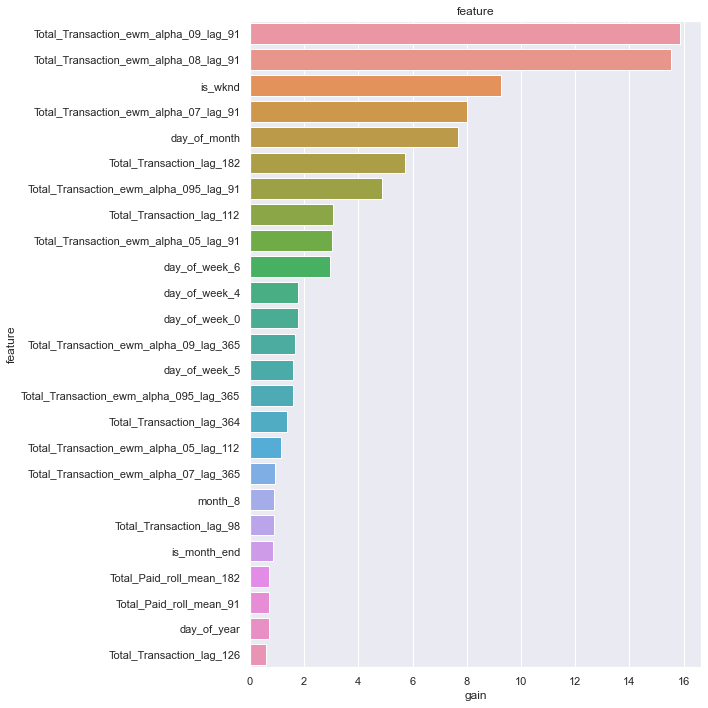

,feature,split,gain
31,Total_Transaction_ewm_alpha_09_lag_91,45,15.861737
40,Total_Transaction_ewm_alpha_08_lag_91,43,15.527485
3,is_wknd,67,9.250423
49,Total_Transaction_ewm_alpha_07_lag_91,41,8.018165
0,day_of_month,310,7.666435
...,...,...,...
110,day_216,0,0.000000
111,day_217,0,0.000000
112,day_218,0,0.000000
113,day_227,0,0.000000


In [29]:
plot_lgb_importances(model, num=30, plot=True)

In [30]:
dff=pd.DataFrame(np.expm1(Y_val))
dff["pred"]=np.expm1(y_pred_val)
dff.head(3)

,Total_Paid,pred
5107,751793.454,1.703739e+06
5114,2872794.960,2.401647e+06
5121,2325575.700,1.873524e+06


<a id = "14" ></a>
# <span style="font-family:serif; font-size:28px;"> 14. Result</span>
<a id = "Undertanding the data" ></a>

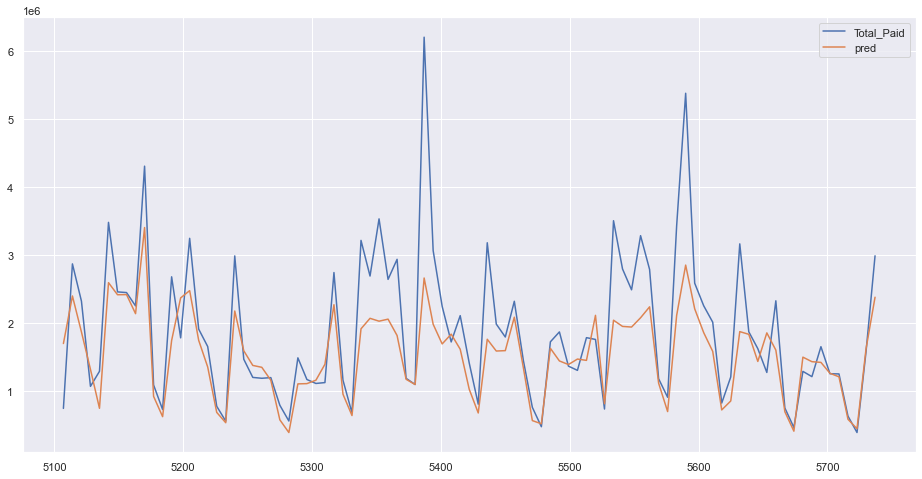

In [32]:
dff['Total_Paid'].plot(legend=True, label="Total_Paid")
dff['pred'].plot(legend=True, label="pred", figsize=(16, 8))
plt.show()

**Estimates and actual data largely overlap.**

**Great result 👍**

<img src="https://amessagewithabottle.com/wp-content/uploads/2019/09/moneyball-1024x550.jpg" width="500">

I hope all of you did gain some insights to Machine Learning. Some other my notebooks for Machine Learning are:

❖ **House Price** Prediction, EDA, ML, Visualization : https://www.kaggle.com/code/mustafayazici/house-price-eda-ml-visualization

❖ **Salary** Prediction with ML Models - ⚾Baseball  : https://www.kaggle.com/code/mustafayazici/salary-prediction-with-ml-models-basebal

❖ **Customer Churn** Prediction :https://www.kaggle.com/code/mustafayazici/telco-churn-prediction

❖ **Customer Segmentation with K-Means Clustering**  : https://www.kaggle.com/code/mustafayazici/customer-segmentation-with-k-means-clustering

❖ **Customer Segmentation with Hierarchical Clustering**  : https://www.kaggle.com/code/mustafayazici/customer-segmentation-with-hierarchical-clustering


❖ **PCA & Clustering :** https://www.kaggle.com/code/mustafayazici/makine-ogrenmesi-modeli-pca-clustering

❖ **User Based** Recommendation : https://www.kaggle.com/code/mustafayazici/user-based-recommendation-system

❖ **Content Based** Recommendation : https://www.kaggle.com/code/mustafayazici/content-based-recommendation

❖ **ARL** Recommendation : https://www.kaggle.com/code/mustafayazici/association-rule-learning-recommendation-system

❖ **My Kaggle** https://www.kaggle.com/mustafayazici/code

❖ **My github** https://github.com/Mustafa-YAZICI?tab=repositories

<img src="https://i.imgflip.com/4of9h0.jpg" width="300">

Please upvote **if you liked** the kernel! 😀

KEEP KAGGLING!